In [1]:
import pandas as pd
import numpy as np
import os
import string
import datetime
from datetime import timezone
os.getcwd()
import glob
import pytz
import seaborn as sns
import re

In [2]:
def convert_mm(value):
    #length in mm transformed to float
    try:
        new_value = value.replace(' mm','')
        return float(new_value)    
    except AttributeError:
        return np.NaN

In [3]:
def convert_exposure(value):
    #length in mm transformed to float
    try:
        list_string=value.split('/')
        if (len(list_string)==1):
            return float(value)
        else:
            return float(list_string[0])/float(list_string[1])
    except AttributeError:
        #print ('WTF',value)
        return np.NaN
    #return float(0)
        

In [4]:
def extract_vatican(source,place,country):
    #all pictures originate from a Pictures folder, remove the full path
    vatican_strings =['Apostolisch',"Vatikan","Petersdom","Santa Maria Maggiore","Lateran","Paolo fuori le Mura",
                     'Scala Scanta','Triclinium Leoninum','Petersplatz','Campo Santo Teutonico',"Sant' Anna",
                     'Sancta Sanctorum','Palazzo Pontifico','Villa Barberini']
    #including Pictures
    if place=="Rom" or place=="Castel Gandolfo":
        for v in vatican_strings:
            if v in source:
                country='Vatican'
    return country

In [5]:
def remove_full_path(value):
    #all pictures originate from a Pictures folder, remove the full path
    #including Pictures
    try:
        list_string=value.split('/Pictures')
        return list_string[1]
    except AttributeError:
        return np.NaN

In [6]:
def extractCityV2(filename):
    m = re.search(r'(?<=\s-\s)\D+?(,)', filename)
    if m==None:
        print("error in",filename)
    else:
        #print("test",m[0][:-1])
        return m[0][:-1]

In [7]:
def funcDayPeriod(filename):
    search_night=["bei Nacht",'Sternenhimmel',"Mondschein","Mond","Ice and Snow/"]
    search_night_special=["Lumiere","euerwerk","Firework","Freudenfeuer"]
    search_twilight=["bei anbrechender Nacht","Abenddaemmerung","Morgendaemmerung","Sonnenaufgang"]
    if any (x in filename for x in search_night):
        return -1
    elif any(x in filename for x in search_night_special):
         return 0
    elif any(x in filename for x in search_twilight):
        return 3
    elif "bei Sonnenuntergang" in filename:
        return 2
    else:
        return 1

In [8]:
def funcComposite(filename):
    if "Panorama." in filename:
        return 1
    else:
        return 0

In [9]:
def funcMovie(filename):
    search_file_names=[".JPG",".jpg",".JPEG",".jpeg"]
    if any(x in filename for x in search_file_names):
        return 0
    else:
        return 1

In [10]:
def funcTimeZoneCorrectionNYCBias(value,filename,modelname,data_min,data_max):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            #date is ordered by 
            #date_orig = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S") 
            date = value
            if modelname=="SP500UZ":
                if(date>data_min and date<data_max):
                #never changed timezone after getting back from NYC, all messed up
                    date=date+datetime.timedelta(hours=6)
            return date
    except AttributeError:
        return np.NaN

In [11]:
def funcTimeZoneCorrection(value,filename,modelname):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            date = value
            search_names_NYC_time_zone=["- Philadelphia,","New York City,","Newark,","Washington Airport"]
            search_names_London_time_zone_CANON600D=["Dublin & Nordirland/P","120830-120909 - Portugal/","Suedengland/","141212-141214 - London/","Greater London"]
            search_names_Istanbul_time_zone_CANON600D=["41023-141027 - Istanbul/","150828-150912 Sankt Petersburg/"]
            search_names_pacific_time_zone_CANON600D=["150613 - Los Angeles/","USA/P818"," - Grand Canyon Village, "," - Boulder City, "," - Las Vegas, "]
            search_names_China_time_zone_CANON80D=["180101 China/","/171230 Shanghai"," - China, "]
            search_names_EastEurope_time_zone_CANON80D=["170603 Athen/","171006 Tallinn ","/170414 Kiev"," - Tuerkei, "," - Irak, "," - Kuwait"," - Qatar, "]
            search_names_London_time_zone_CANON80D=[" - Saudi-Arabien,","/190413-190417 Suedostengland/"," - United Kingdom - ","/171110 Marrakesch/","170915 London/P","/180602 UK/"]
            search_names_Iceland_time_zone_CANON80D=[" - Island, ","/180328 Island/"]
            search_names_Gulf_time_zone_CANON80D=[" - Island, "," - Dubai, "]
            search_names_Pakistan_time_zone_CANON80D=[" - Pakistan, "]
            search_names_Korea_time_zone_CANON80D=[" - Paju, "," - Suwon, "," - Seoul, "," - Busan,"," - Incheon, "," - Gyeongju, "," - Gwanju, "]
            if modelname=="SP500UZ":
                hour_bias=0
                data_max_olympus=datetime.datetime.now()
                date_max_olympus=datetime.date(2008,9,1)
                if(date.date()<date_max_olympus):
                    hour_bias=24
                #no change of default time, thus London time is an hour too late
                if "London/P" in filename:  
                    date=date-datetime.timedelta(hours=1)+datetime.timedelta(hours=hour_bias)
                    return date
                elif any(x in filename for x in search_names_NYC_time_zone):
                    date=date-datetime.timedelta(hours=6)+datetime.timedelta(hours=hour_bias)
                    return date
                elif " Chicago - Edit2012/P" in filename:
                    date=date-datetime.timedelta(hours=7)+datetime.timedelta(hours=hour_bias)
                    return date    
                else:
                    value_new=date+datetime.timedelta(hours=hour_bias)
                    return value_new
            if modelname=="Canon EOS 600D":
                #all of EOS600D done including 2015
                if any(x in filename for x in search_names_London_time_zone_CANON600D):
                    date=date-datetime.timedelta(hours=1)
                    return date
                elif any(x in filename for x in search_names_Istanbul_time_zone_CANON600D):
                    date=date+datetime.timedelta(hours=1) 
                    return date
                elif any(x in filename for x in search_names_pacific_time_zone_CANON600D):
                    date=date-datetime.timedelta(hours=9)
                    return date
                elif "- Chicago, " in filename:
                    date=date-datetime.timedelta(hours=7)
                    return date
                elif " - Washington D.C., " in filename:
                    date=date-datetime.timedelta(hours=6)
                    return date
                elif "/160813 - USA/" in filename:
                    #remaining 2016 US trip times
                    date=date-datetime.timedelta(hours=8)
                    return date
                elif "161205 - Japan/" in filename:
                    date=date+datetime.timedelta(hours=7)
                    return date
                else:
                    #change to default summer time
                    return date
            if modelname=="Canon PowerShot S110":  
                 #all running on summer time
                if any(x in filename for x in search_names_London_time_zone_CANON600D): 
                    date=date-datetime.timedelta(hours=2)
                    return date
                elif "41023-141027 - Istanbul/" in filename:
                    #for Istanbul timezone was not aligned with CANON EOS600D
                    date=date-datetime.timedelta(hours=1)
                    return date
                elif "150613 - Los Angeles/" in filename:
                    date=date-datetime.timedelta(hours=10)
                    return date
                elif "/2016/" in filename:
                    if "161205 - Japan/" in filename:
                        date=date+datetime.timedelta(hours=6)
                        return date
                    else:
                        #change to default summer time
                        date=date-datetime.timedelta(hours=1)
                        return date
                else:
                    #change to default summer time
                    date=date-datetime.timedelta(hours=1)
                    return date
            if modelname=="Canon EOS 80D":
                if any(x in filename for x in search_names_China_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=6)
                    return date
                elif any(x in filename for x in search_names_EastEurope_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=1)
                    return date
                elif any(x in filename for x in search_names_London_time_zone_CANON80D):
                    date=date-datetime.timedelta(hours=1)
                    return date
                elif " - Groenland" in filename:
                    date=date-datetime.timedelta(hours=4)
                    return date
                elif any (x in filename for x in search_names_Iceland_time_zone_CANON80D):
                    date=date-datetime.timedelta(hours=2)
                    return date
                elif "/170609 USA/" in filename:
                    date=date-datetime.timedelta(hours=8)
                    return date
                elif any(x in filename for x in search_names_Gulf_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=2)
                    return date
                elif any(x in filename for x in search_names_Pakistan_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=3)
                    return date
                elif any(x in filename for x in search_names_Korea_time_zone_CANON80D):
                    date=date+datetime.timedelta(hours=7)
                    return date
                else:
                    #always on summer time
                    return date
    except AttributeError:
        return np.NaN

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


dataframe_list=[]

datamax=datetime.datetime.now()
datamin=datetime.datetime.now()


"""    
columns_to_keep=['SourceFile','Aperture','AspectRatio','AutoISO','BaseISO','BitsPerSample',
                'ColorSpace','ColorTemperature','Contrast','DateTimeOriginal','DateTimeOriginal'
                    'ExposureTime','FileName','Flash','FocalLength','FocalLength35efl','ImageSize',
                    'ImageWidth','ISO','Lens','Lens35efl','LightValue','MaxAperture','MinAperture','MinFocalLength',
                     'Model','Orientation','PictureStyle','Quality','RedBalance','ShutterSpeed',
                    'TargetAperture','TimeZone','TimeZoneCity','WB_RGGBLevels','WB_RGGBLevelsAsShot',
                    'WBBracketMode','WhiteBalance','WhiteBalanceBlue','WhiteBalanceRed']
"""

for input in range(2006,2021):
    #print("get to year",input)
    file_name=("outputEXIFcsvsFullInfo/PhotoEXIFDataFull_%s.csv"%(str(input)))
#    df=pd.read_csv(file_name)
#    df=df.dropna(subset=['BitsPerSample'])
    df_test=pd.read_csv(file_name, encoding= 'unicode_escape')
    df_test=df_test.dropna(subset=['BitsPerSample'])
#for c in df_test.columns:
#    print("col",c,df_test[c].isna().sum(),df_test.shape)

    columns_to_keep=['SourceFile','Aperture','BitsPerSample','ColorSpace','Contrast',
                 'DateTimeOriginal','ExposureTime','FileName','Flash','FocalLength','CreateDate',
                 'FocalLength35efl','ImageSize','ImageWidth','ISO','LightValue','Model','Orientation',
                 'Quality','ShutterSpeed','WhiteBalance']
    df_test=df_test[columns_to_keep]
    df_test["Place"]=df_test.apply(lambda x: extractCityV2(x['SourceFile']), axis=1)
    df_test['SourceFile']=df_test['SourceFile'].apply(remove_full_path)    
    df_test['FocalLength']=df_test['FocalLength'].apply(convert_mm) 
    df_test['ExposureTime']=df_test['ExposureTime'].apply(convert_exposure)
    df_test=df_test.replace({'DateTimeOriginal': {'0000:00:00 00:00:00': '2006:01:10 15:20:30'}})
    df_test['DateTimeOriginal']=pd.to_datetime(df_test['DateTimeOriginal'],format='%Y:%m:%d %H:%M:%S')
    df_test['year']=int(input)
    df_test['dayperiod']=df_test.apply(lambda x: funcDayPeriod(x['SourceFile']), axis=1)
    df_test['CompositePhoto']=df_test.apply(lambda x: funcComposite(x['SourceFile']), axis=1)
    df_test['Movie']=df_test.apply(lambda x: funcMovie(x['SourceFile']), axis=1)
    df_test.rename(columns={'DateTimeOriginal':'Date','FocalLength':'FocalLength in mm'},inplace=True) 
    df_test['Date']=df_test.apply(lambda x: funcTimeZoneCorrection(x['Date'],x['SourceFile'],x['Model']), axis=1)
    #total_rows=df_test['SourceFile'].count()
    if(input==2009 or input ==2010):
        if input==2009:
            test=df_test.loc[df_test['SourceFile'].str.contains("P7080022 - New York City")]
            datamin=df_test.at[test.index.values.astype(int)[0],"Date"]   
            print("correction should begin somewhere here 2009",test,"index is",test.index.values.astype(int)[0],datamin)
            df_test['Date']=df_test.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
        elif input==2010:    
            test=df_test.loc[df_test['SourceFile'].str.contains("P8270068 - Le Locle, unterirdische Muehlen")]
            print("correction should end somewhere here 2010",test,"index is",test.index.values.astype(int)[0],datamax)
            datamax=df_test.at[test.index.values.astype(int)[0],"Date"] 

            df_test['Date']=df_test.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
    dataframe_list.append(df_test)
#df = pd.DataFrame(dataframe_list, columns=columns_to_keep)
#print(dataframe_list[0])

combine_all_data=pd.DataFrame(dataframe_list[0]) 
dataframe_list.pop(0)
for data in dataframe_list:
        #print(data.head)
    combine_all_data=pd.concat([combine_all_data,data],ignore_index=True,sort=False)


combine_all_data.to_csv("pictureData/PhotoEXIFDataStripped_2006_2020.csv")
combine_all_data


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,4,6,7,8,9,12,13,14,15,21,22,24,34,40,42,44,45,46,48,49,51,71,79,81,82,83,84,86,87,94,104,110,111,112,115,122,130,136,140,142,143,145,149,150,151,152,158,160,162,163,164,165,166,167,169,177,195,204,205,206,209,212,213,216,218,219,220,223,226,239,240,241,242,245,246,247,250,256,257,262,265,288,290,295,300,301,308,310,319,321,322,325,326,327,328,332,335,336,337,338,339,340,345,347,349,353,354,355,357,364,365,366,367,368,369,370,371,372,373,374,375,376,394,395) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,3,6,7,10,11,14,15,19,21,23,24,29,30,34,36,38,39,40,42,43,45,46,48,49,51,53,54,58,59,60,61,63,66,67,70,71,72,73,76,77,78,79,80,81,82,85,86,87,88,89,90,91,107,114,116,125,127,129,130,131,

correction should begin somewhere here 2009                                              SourceFile  Aperture  \
3277  /2009/090623 USA CTEQ09/090703 New York City/P...       3.0   

      BitsPerSample ColorSpace Contrast                Date  ExposureTime  \
3277            8.0       sRGB   Normal 2009-07-08 13:48:04        0.0125   

                                               FileName              Flash  \
3277  P7080022 - New York City, Lufthansa Boeing 747...  Off, Did not fire   

      FocalLength in mm  ...    Model          Orientation      Quality  \
3277                7.8  ...  SP500UZ  Horizontal (normal)  HQ (Normal)   

      ShutterSpeed  WhiteBalance          Place  year dayperiod  \
3277          1/80          Auto  New York City  2009         1   

     CompositePhoto Movie  
3277              0     0  

[1 rows x 26 columns] index is 3277 2009-07-08 13:48:04


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,3,4,5,6,7,8,11,13,21,23,25,26,39,40,41,43,45,46,47,49,50,52,54,55,73,74,76,78,79,80,90,93,97,99,109,115,117,118,119,120,137,145,147,149,150,152,155,156,160,162,164,166,167,168,169,170,171,172,173,180,185,186,187,188,190,196,213,214,216,218,224,225,226,228,229,232,247,250,253,261,262,264,272,278,279,280,286,291,308,310,313,315,316,317,318,321,322,323,345,346,372,373,374,376,385,389,399,400,401,402,403,407,410,416,417,418,419,423,424,426,428) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


correction should end somewhere here 2010                                              SourceFile  Aperture  \
5389  /2010/100827 Jura/P8270068 - Le Locle, unterir...       2.8   

      BitsPerSample ColorSpace Contrast                Date  ExposureTime  \
5389            8.0       sRGB   Normal 2010-08-27 16:15:55           2.5   

                                            FileName              Flash  \
5389  P8270068 - Le Locle, unterirdische Muehlen.JPG  Off, Did not fire   

      FocalLength in mm  ...    Model   Orientation Quality  ShutterSpeed  \
5389                6.3  ...  SP500UZ  Rotate 90 CW     NaN           2.5   

      WhiteBalance     Place  year dayperiod CompositePhoto Movie  
5389          Auto  Le Locle  2010         1              0     0  

[1 rows x 26 columns] index is 5389 2020-12-31 19:43:11.477529


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,2,5,6,7,9,15,16,17,19,29,32,37,38,39,41,42,44,45,54,56,61,63,64,68,74,75,76,78,80,82,83,84,92,98,100,101,102,111,114,122,136,138,139,140,142,149,151,153,156,157,158,159,160,165,167,170,171,172,173,174,180,184,189,192,195,202,208,209,212,213,214,215,219,221,222,223,226,227,228,231,239,242,256,257,260,261,264,266,273,278,279,280,281,283,284,285,287,288,290,293,307,312,323,325,332,333,344,345,348,350,355,359,360,361,362,367,370,374,375,381,387,389,390,391,400) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,5,12,15,16,28,32,34,49,50,51,52,64,65,73,109,118,134,135,137,138,140,145,161,179,180,191,200,212,214,215,219,220,225,232,240,241,245,250,253,255,256,259,260,261,263,273,276,282,290,293,

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,Date,ExposureTime,FileName,Flash,FocalLength in mm,...,Model,Orientation,Quality,ShutterSpeed,WhiteBalance,Place,year,dayperiod,CompositePhoto,Movie
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",18.5,...,SP500UZ,NaN,SQ (Low),1/125,Auto,Frankreich,2006,1,0,0
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",33.0,...,SP500UZ,NaN,SQ (Low),1/250,Auto,Frankreich,2006,1,0,0
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4,8.0,sRGB,Normal,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",20.9,...,SP500UZ,Horizontal (normal),HQ (Normal),1/500,Auto,Les Houches,2006,1,0,0
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4,8.0,sRGB,Normal,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",14.9,...,SP500UZ,Horizontal (normal),HQ (Normal),1/800,Auto,Chamonix,2006,1,0,0
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4,8.0,sRGB,Normal,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",14.9,...,SP500UZ,Horizontal (normal),HQ (Normal),1/200,Auto,Chamonix,2006,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102316,/2020/201201-201228 - Lauchringen/PC110001 - L...,3.5,8.0,sRGB,Normal,2020-12-11 20:28:08,30.00000,"PC110001 - Lauchringen, Dorf im Schnee.JPG","Off, Did not fire",18.0,...,Canon EOS 80D,Horizontal (normal),Normal,30,Auto,Lauchringen,2020,1,0,0
102317,/2020/201201-201228 - Lauchringen/PC010006 - L...,5,8.0,sRGB,Normal,2020-12-01 09:08:01,0.02000,"PC010006 - Lauchringen, Baeume mit Schnee.JPG","Off, Did not fire",56.0,...,Canon EOS 80D,Horizontal (normal),Normal,1/50,Auto,Lauchringen,2020,1,0,0
102318,/2020/201201-201228 - Lauchringen/PC030003 - L...,5.6,8.0,sRGB,Normal,2020-12-03 14:55:21,0.00500,"PC030003 - Lauchringen, Kuessaberg mit Kuessab...","Off, Did not fire",135.0,...,Canon EOS 80D,Horizontal (normal),Normal,1/200,Daylight,Lauchringen,2020,1,0,0
102319,/2020/201201-201228 - Lauchringen/PC010014 - L...,7.1,8.0,sRGB,Normal,2020-12-01 11:18:33,0.00625,"PC010014 - Lauchringen, Wald mit Schnee.JPG","Off, Did not fire",42.0,...,Canon EOS 80D,Horizontal (normal),Normal,1/160,Auto,Lauchringen,2020,1,0,0


In [13]:
combine_all_data[combine_all_data["year"]==2020]["Place"].nunique()

96

In [14]:
dict_place_to_country = {'Frankreich': 'France', 'Chamonix': 'France', 'Montenvers': 'France', 'Les Houches': 'France', 'Basel': 'Switzerland',
       'London': 'United Kingdom', 'Windsor': 'United Kingdom', 'Meyrin': 'Switzerland', 'Genf': 'Switzerland', 'Kuessaberg': 'Germany',
       'Lauchringen': 'Germany', 'Goerwihl': 'Germany', 'Tiengen': 'Germany', 'Zuerich':'Switzerland', 'Schweiz':'Switzerland',
       'Zermatt':'Switzerland', 'Sion':'Switzerland', 'St Niklaus':'Switzerland', 'Randa':'Switzerland', 'Singen': 'Germany', 'Birnau': 'Germany',
       'Meersburg': 'Germany', 'Cessy':'France', 'Carouge':'Switzerland', 'Lausanne':'Switzerland', 'Zurzach':'Switzerland',
       'Einsiedeln':'Switzerland', 'Schwyz':'Switzerland', 'Montreux':'Switzerland', 'Aarau':'Switzerland', 'Veytaux':'Switzerland',
       'Villeneuve':'Switzerland', 'Naefels':'Switzerland', 'St Gallen':'Switzerland', 'Dresden': 'Germany', 'Meissen': 'Germany',
       'Moritzburg': 'Germany', 'Annecy': 'France', 'Frankfurt': 'Germany', 'Philadelphia': 'USA', 'Madrid':'Spain',
       'El Escorial':'Spain', 'Segovia':'Spain', 'Lauterbrunnen':'Switzerland',
       'Grindelwald':'Switzerland', 'Fieschertal':'Switzerland', 'Nuernberg': 'Germany', 'St Blasien': 'Germany', 'Sarnen':'Switzerland',
       'Neuchatel':'Switzerland', 'Solothurn':'Switzerland', 'Bern':'Switzerland', 'Konstanz': 'Germany', 'Reichenau': 'Germany',
       'Rheinau':'Switzerland', 'Morges': 'France', 'Nyon': 'France', 'Paris': 'France', 'Hebron':'USA',
       'Madison': 'USA', 'Chicago': 'USA', 'New York City': 'USA', 'Jersey City': 'USA', 'Getafe':'Spain',
       'Toledo':'Spain', 'St Maurice':'Switzerland', 'St Leonhard':'Switzerland', 'Brig':'Switzerland',
       'Karlsruhe': 'Germany', 'Mainz': 'Germany', 'Speyer': 'Germany', 'Fankfurt': 'Germany', 'Mannheim': 'Germany', 'Worms': 'Germany',
       'Heidelberg': 'Germany', 'Wutach': 'Germany', 'Innsbruck':'Austria', 'Telfs':'Austria',
       'Feldkirch':'Austria', 'Coppet':'Switzerland', 'Schaffhausen':'Switzerland', 'Sargans':'Switzerland', 'Breitenfeld':'Germany',
       'Oesterreich':'Austria', 'Fribourg':'Switzerland', 'Brienz':'Switzerland', 'Meiringen':'Switzerland', 'Interlaken':'Switzerland',
       'Stechelberg':'Switzerland', 'Zweitluetschinen':'Switzerland', 'Thun':'Switzerland',
       'Argentiere': 'France', 'Luzern':'Switzerland', 'Rosenlaui':'Switzerland', 'Fiesch':'Switzerland', 'Riederalp':'Switzerland',
       'Oberwald':'Switzerland', 'Realp':'Switzerland', 'Hasel': 'Germany', 'Hechingen': 'Germany', 'Rottweil': 'Germany',
       'Donaueschingen': 'Germany', 'Versailles': 'France', 'Chartres': 'France', 'Fontainebleau': 'France',
       'St Denis': 'France', 'Vincennes': 'France', 'Puteaux': 'France', 'Reims': 'France', 'Les Brenets':'Switzerland',
       'Le Locle':'Switzerland', 'Les Diablerets':'Switzerland', 'Saas Fee':'Switzerland', 'Saas Grund':'Switzerland', 'Visp':'Switzerland',
       'Ascona':'Switzerland', 'Locarno':'Switzerland', 'Bellinzona':'Switzerland', 'Lugano':'Switzerland', 'Como': 'Italy', 'Engelberg':'Switzerland',
       'Martigny':'Switzerland', 'Tour':'France', 'Hoechenschwand': 'Germany', 'Hohenschwangau': 'Germany', 'Fuessen': 'Germany',
       'Steingaden': 'Germany', 'Schwangau': 'Germany', 'Muenchen': 'Germany', 'Ehrwald':'Austria',
       'Garmisch-Partenkirchen': 'Germany', 'Ettal': 'Germany', 'Grainau': 'Germany', 'Ulm': 'Germany', 'Augsburg': 'Germany',
       'Saint Denis': 'France', 'Mailand':'Italy', 'Flegere': 'France', 'Les Houches': 'France', 'Charmonix': 'France',
       'Breitnau': 'Germany', 'Freiburg': 'Germany', 'Feldberg':'Germany', 'Vernayaz':'Switzerland',
       'Vallorbe':'Switzerland', 'Lyon': 'France', 'Stein':'Switzerland', 'Bad Saeckingen': 'Germany', 'Leibstadt':'Switzerland',
       'Mainau': 'Germany', 'Gadmen':'Switzerland', 'Saas Almagell':'Switzerland', 'Ludwigsburg': 'Germany', 'Hintertux': 'Austria',
       'Zell am Ziller': 'Austria', 'Wuerzburg': 'Germany', 'Bamberg': 'Germany', 'Bad Staffelstein': 'Germany',
       'Banz': 'Germany', 'Coburg': 'Germany', 'Pommersfelden': 'Germany', 'Kloten':'Switzerland', 'Wien': 'Austria', 'Rust': 'Germany',
       'Batavia': 'USA', 'Newark': 'USA', 'USA': 'USA', 'Ferney-Voltaire': 'France', 'Vevey':'Switzerland',
       'Chambessy':'Switzerland', 'Deutschland': 'Germany', 'Karlstejn':'Czech Republic', 'Prag':'Czech Republic', 'Spiez':'Switzerland',
       'Oberhofen':'Switzerland', 'Hilterfingen':'Switzerland', 'Leukerbad':'Switzerland', 'Leuk':'Switzerland', 'Berlin': 'Germany',
       'Potsdam': 'Germany', 'Unteruhldingen': 'Germany', 'Spanien':'Spain', 'Oeiras':'Portugal',
       'Lissabon':'Portugal', 'Portugal':'Portugal', 'Belem':'Portugal', 'Sintra':'Portugal', 'Mafra':'Portugal', 'Queluz':'Portugal',
       'Coimbra':'Portugal', 'Tomar':'Portugal', 'Cascais':'Portugal', 'Porto':'Portugal', 'Guttannen':'Switzerland', 'Krakau':'Poland',
       'Warschau':'Poland', 'Chenonceau': 'France', 'Chaumont': 'France', 'Cheverny': 'France',
       'Blois': 'France', 'Amboise': 'France', 'Orleans': 'France', 'Chaumont-sur-Loire': 'France', 'Chambord': 'France',
       'Vezelay': 'France', 'Cluny': 'France', 'Amsterdam':'Netherlands', 'Apeldoorn':'Netherlands', 'Den Haag':'Netherlands',
       'Soestdijk':'Netherlands', 'Satigny':'Switzerland', 'Prevessin':'France', 'Hermance':'Switzerland',
       'Italien':'Italy', 'Tivoli':'Italy', 'Rom':'Italy', 'Lido Azzuro':'Italy',
       'Ostia':'Italy', 'Grandvaux':'Switzerland', 'Thoiry': 'France', 'Riedern am Wald': 'Germany',
       'Venedig':'Italy', 'Prangins':'Switzerland', 'Compiegne': 'France', 'Chantilly': 'France', 'Malmaison': 'France',
       'Maisons-Lafitte': 'France', 'Champs-sur-Marne': 'France', 'Vaux-le-Vicomte': 'France',
       'Strassburg': 'France', 'Ayze': 'France', 'Stockholm':'Sweden', 'Kopenhagen':'Denmark', 'Drottningholm':'Sweden',
       'Ulriksdal':'Sweden', 'Soedertalje Sued':'Sweden', 'Mariefred':'Sweden', 'Skokloster':'Sweden',
       'Rosersberg':'Sweden', 'Helsingor':'Denmark', 'Hillerod':'Denmark', 'Fredensborg':'Denmark', 'Stresa':'Italy',
       'Baveno':'Italy', 'Domodossola':'Italy', 'Kempten':'Germany', 'Rosenheim':'Germany', 'Prien':'Germany',
       'Herrenchiemsee':'Germany', 'Landshut':'Germany', 'Schleissheim':'Germany', 'Sigmaringen':'Germany',
       'Beuron':'Germany', 'Bovernier ': 'Switzerland', 'Istanbul': 'Turkey', 'Serbien': 'Serbia', 'Kroatien': 'Croatia',
       'Frankreich & Italien': 'France', 'Totland': 'United Kingdom', 'Bath': 'United Kingdom', 'Eton': 'United Kingdom', 'Portsmouth': 'United Kingdom',
       'Hatfield': 'United Kingdom', 'Seaford': 'United Kingdom', 'Brighton': 'United Kingdom', 'Ryde': 'United Kingdom', 'East Cowes': 'United Kingdom',
       'Yarmouth': 'United Kingdom', 'Dover': 'United Kingdom', 'Lymington': 'United Kingdom', 'Woodstock': 'United Kingdom', 'Oxford': 'United Kingdom', 'UK': 'United Kingdom',
       'Rochester': 'United Kingdom', 'Canterbury': 'United Kingdom', 'Amesbury': 'United Kingdom', 'Salisbury': 'United Kingdom',
       'Devinska Nova Ves':'Slovakia', 'Goedoello':'Hungary', 'Eisenstadt':'Austria', 'Neusiedl am See':'Austria',
       'Fertoed':'Hungary', 'Bratislava':'Slovakia', 'Devin':'Slovakia', 'Schlosshof':'Austria', 'Budapest':'Hungary',
       'Bologna':'Italy', 'Florenz':'Italy', 'Pisa':'Italy', 'Siena':'Italy', 'Montalchez':'Switzerland', 'Genthod':'Switzerland',
       'Russin':'Switzerland', 'Bourdigny-Dessous':'Switzerland', 'Monza':'Italy', 'Sevilla':'Spain', 'Granada':'Spain',
       'Cordoba':'Spain', 'La Granja':'Spain', 'Aranjuez':'Spain', 'El Pardo':'Spain', 'Passy': 'France', 'Monaco': 'Monaco',
       'Beaulieu-sur-Mer': 'France', "Cap d'Ail": 'France', 'Nizza': 'France', 'Villefranche-sur-Mer': 'France',
       'Irland': 'Ireland', 'Los Angeles': 'USA', 'Long Beach': 'USA', 'Pasadena': 'USA',
       'Pacific Palisades': 'USA', 'Mont-Saint-Michel':'France', 'Pompei':'Italy',
       'Ottaviano':'Italy', 'Torre Annunziata':'Italy', 'Neapel':'Italy', 'Pozzuoli':'Italy', 'Portici':'Italy',
       'Castellammare di Stabia':'Italy', 'Caserta':'Italy', 'Erding': 'Germany', 'Niederlande':'Netherlands',
       'Kronstadt':'Russia', 'Peterhof':'Russia', 'Strelna':'Russia', 'St Petersburg':'Russia', 'Lomonosow':'Russia',
       'Pawlovsk':'Russia', 'Gatchina':'Russia', 'Moskau':'Russia', 'Olgino':'Russia', 'Puschkin':'Russia', 'Hamburg': 'Germany',
       'Rudolstadt': 'Germany', 'Schwerin': 'Germany', 'Luebeck': 'Germany', 'Weimar': 'Germany', 'Erfurt': 'Germany', 'Fulda': 'Germany',
       'Jena': 'Germany', 'Gotha': 'Germany', 'Taesch':'Switzerland', 'Melk':'Austria', 'Wildbad Kreuth': 'Germany', 'Tegernsee': 'Germany',
       'Goettweig':'Austria', 'Passau': 'Germany', 'Salzburg':'Austria', 'Colmar':'France', 'Catania':'Italy',
       'Piazza Armerina':'Italy', 'Cefalu':'Italy', 'Monreale':'Italy', 'Palermo':'Italy', 'Calatafimi':'Italy',
       'Castellammare del Golfo':'Italy', 'Selinunt':'Italy', 'Realmonte':'Italy', 'Agrigent':'Italy',
       'Comiso':'Italy', 'Noto':'Italy', 'Syrakus':'Italy', 'Nicolosi':'Italy', 'Barcelona':'Spain',
       'Saragossa':'Spain', 'Gruyeres':'Switzerland', 'Broc':'Switzerland', 'Waldshut': 'Germany', 'Venaria Reale':'Italy',
       'Turin':'Italy', 'Racconigi':'Italy', 'Aglie':'Italy', 'Nichelino':'Italy', 'Monterosso al Mare':'Italy',
       'Riomaggiore':'Italy', 'Pollein':'Italy', 'Genua':'Italy', 'Manarola':'Italy', 'Corniglia':'Italy',
       'Vernazza':'Italy', 'San Bernardino':'Italy', 'Aostatal':'Italy', 'Courmayeur':'Italy',
       'Santander':'Spain', 'Bilbao':'Spain', 'Puente Viesgo':'Spain', 'Burgos':'Spain', 'Somo':'Spain',
       'Le Chable':'Switzerland', 'Verbier':'Switzerland', 'Hermence':'Switzerland', 'Little Elm':'USA', 'Dagenham': 'United Kingdom',
       'Sligo': 'Ireland', 'Dartford':'United Kingdom', 'Kanada':'Canada', 'Lake Dalles':'USA', 'Dallas':'USA',
       'Lewisville':'USA', 'Fort Worth':'USA', 'Longford': 'Ireland', 'Frisco':'USA', 'Bordeaux': 'France',
       'Saint-Gervais-les-Bains': 'France', 'Ravenna':'Italy', 'Classe':'Italy', 'Padua':'Italy',
       'Santiago de Compostela':'Spain', 'Koeln': 'Germany', 'Duesseldorf': 'Germany',
       'Friedrichssegen': 'Germany', 'Limburg': 'Germany', 'Bruehl': 'Germany', 'Bonn': 'Germany', 'Mantua':'Italy', 'Verona':'Italy',
       'Russland': 'Russia', 'Tokio':'Japan', 'Morioka':'Japan', 'Hiraizumi':'Japan', 'Japan':'Japan', 'Nikko':'Japan',
       'Utsunomiya':'Japan', 'Kyoto':'Japan', 'Himeji':'Japan', 'Nara':'Japan', 'Ikaruga':'Japan', 'Hiroshima':'Japan',
       'Fukuyama':'Japan', 'Uji':'Japan', 'China':'China', 'Hatsukaichi':'Japan', 'Osaka':'Japan', 'Springdale':'USA',
       'Las Vegas': 'USA', 'Bruessel': 'Belgium', 'Aurora': 'USA', 'Boulder City': 'USA',
       'Grand Canyon Village': 'USA', 'Tusayan': 'USA', 'Cameron': 'USA', 'Page': 'USA', 'Kaibito': 'USA',
       'Oljato-Monument Valley': 'USA', 'Halchita': 'USA', 'Mexican Hat': 'USA', 'Bluff': 'USA',
       'Aneth': 'USA', 'Montezuma Creek':'USA', 'Ute Mountain Reservation': 'USA', 'Cortez': 'USA',
       'Moab': 'USA', 'San Rafael Swell': 'USA', 'Emery': 'USA', 'Garfield': 'USA',
       'Bryce Canyon City': 'USA', 'Mount Carmel': 'USA', 'Virgin': 'USA', 'Washington D.C.': 'USA',
       'Aachen': 'Germany', 'Koekelberg':'Belgium', 'Dublin':'Ireland', 'Ballymoney': 'United Kingdom', 'Ballycastle': 'United Kingdom',
       'Bushmills': 'United Kingdom', 'Belfast': 'United Kingdom', 'Avignon': 'France', 'Carcassonne':'France',
       'Villeneuve-les-Avignon':'France', 'Bruegge':'Belgium', 'Gent': 'Belgium', 'Antwerpen': 'Belgium',
       'Oberalpfen':'Switzerland', 'Villers-le-Lac':'France', 'Le Cerneux-Pequignot':'Switzerland', 'Assisi': 'Italy',
       'Perugia': 'Italy', 'Kiew':'Ukraine', 'Boryspil':'Ukraine', 'Aschaffenburg': 'Germany', 'Wiesbaden': 'Germany',
       'Bruchsal': 'Germany', 'Kassel': 'Germany', 'Salamanca':'Spain', 'Valencia':'Spain', 'Leon':'Spain', 'Oviedo':'Spain',
       'Avila':'Spain', 'Athen': 'Greece', 'Delphi': 'Greece', 'Twin Falls': 'USA', 'West Yellowstone': 'USA',
       'Norris': 'USA', 'Lake Village': 'USA', 'Le Mesnil-Amelot':'France', 'Island':'Iceland', 'Drancy':'France',
       'Groenland':'Denmark', None: 'Ocean', 'Fort Peck (MT)': 'USA', 'Bondy':'France', 'Bruneau': 'USA', 'Bliss': 'USA',
       'Salmon Springs': 'USA', 'Arco': 'USA', 'Gardiner': 'USA', 'Canyon Village': 'USA',
       'Roosevelt': 'USA', 'Island Park': 'USA', 'Grant Village': 'USA', 'Ashton': 'USA', 'Jackson': 'USA',
       'Afton': 'USA', 'Salt Lake City': 'USA', 'Magna': 'USA', 'Le Bourget': 'France',
       'Neueilly-Plaisance': 'France', 'Bonneuil-sur-Marne': 'France', 'Perreux-sur-Marne': 'France',
       'Adamville': 'USA', 'Champigny-sur-Marne':'France', 'Loreto':'Italy', 'Ancona':'Italy', 'Vicenza':'Italy',
       'Stra':'Italy', 'Ferrara':'Italy', 'Divaca':'Slovenia', 'Porec':'Croatia', 'Trieste':'Italy', 'Aquileia':'Italy',
       'Cividale del Friuli':'Italy', 'Sgonico':'Italy', 'Zaventem':'Belgium', 'Gardermoen':'Norway', 'Oslo':'Norway',
       'Garching':'Germany', 'Les-Diablerets':'Switzerland', 'Trogir':'Croatia', 'Split':'Croatia', 'Fiumicino':'Italy',
       'Rapallo':'Italy', 'Chiavari':'Italy', 'Graz':'Austria', 'Feldkirchen':'Austria', 'Helsinki':'Finland',
       'Tallinn':'Estonia', 'Estland':'Estonia', 'Finnland':'Finland', 'Schwechat':'Austria', 'Marrakesch':'Morocco',
       'Abadou':'Morocco', 'Tiglatine':'Morocco', 'Toufliht':'Morocco', "Tizi N'Tichka":'Morocco', 'Casablanca':'Morocco',
       'Telouet':'Morocco', 'Ounila Tal':'Morocco', 'Ait Ben Haddou':'Morocco', 'Marokko':'Morocco',
       'Douar Ait-Imgeur':'Morocco', 'Cadiz':'Spain', 'Osuna':'Spain', 'Ecija':'Spain', 'Marmagne': 'France',
       'Arc-et-Senans':'Switzerland', 'Besancon':'France', 'Shanghai':'China', 'Beijing':'China', 'Hongkong':'China',
       'Suzhou':'China', 'Hangzhou':'China', 'Luzhi Stadt':'China', 'Kunshan':'China', 'Nanjing':'China',
       'Juyongguan':'China', 'Badaling':'China', 'Luoyang':'China', "Xi'an": 'China', 'Sanmenxia': 'China',
       'Zhuhai':'China', 'Macau':'China', 'Toulouse':'France', 'Albi':'France', 'Haukadalur Tal':'Italy',
       'Reykjavik':'Iceland', 'Vik i Myrdal':'Iceland', 'Keflavik':'Iceland', 'Freising':'Germany', 'Roskilde':'Denmark',
       'Kastrup':'Denmark', 'Bayeux': 'France', 'Caen': 'France', 'Rouen': 'France', 'Amiens': 'France', 'Buehl':'Germany',
       'Baden-Baden': 'Germany', 'Certosa di Pavia':'Italy', 'Pavia':'Italy', 'Brescia':'Italy', 'Bergamo':'Italy',
       'Cremona':'Italy', 'Rimini':'Italy', 'San Marino': 'San Marino', 'Figueras':'Spain', 'Tarragona':'Spain',
       'Castelldefels':'Spain', 'Crawley': 'United Kingdom', 'Falkirk': 'United Kingdom', 'York': 'United Kingdom', 'Edinburgh': 'United Kingdom',
       'Stirling': 'United Kingdom', 'Linlithgow': 'United Kingdom', 'Queensferry': 'United Kingdom', 'North Queensferry': 'United Kingdom',
       'Glasgow': 'United Kingdom', 'Durham': 'United Kingdom', 'Knaresborough': 'United Kingdom', 'Ripon': 'United Kingdom', 'Kilburn': 'United Kingdom',
       'Bakewell': 'United Kingdom', 'Sheffield': 'United Kingdom', 'Lincoln': 'United Kingdom', 'Manchester':'United Kingdom', 'Conwy': 'United Kingdom',
       'Caernarfon': 'United Kingdom', 'Bangor': 'United Kingdom', 'Liverpool': 'United Kingdom', 'Chester': 'United Kingdom', 'Seoul':'South Korea', 'Ungarn':'Hungary',
       'Rumaenien':'Romania', 'Bulgarien':'Bulgaria', 'Tuerkei':'Turkey', 'Irak':'Iraq', 'Kuwait':'Kuwait', 'Dubai':'United Arab Emirates',
       'Pakistan': 'Pakistan', 'Incheon':'South Korea', 'Paju':'South Korea', 'Suwon':'South Korea', 'Gwangju':'South Korea', 'Gyeongju':'South Korea',
       'Busan':'South Korea', 'Qatar':'Qatar', 'Saudi-Arabien':'Saudi-Arabia',
       'United Arab Emirates':'United Arab Emirates', 'Klosters':'Switzerland', 'Samedan':'Switzerland', 'Pontresina':'Switzerland',
       'Tomils':'Switzerland', 'Chur':'Switzerland', 'Leaz':'Switzerland', 'Waldshut-Tiengen': 'Germany', 'Kandersteg':'Switzerland',
       'bei Frutigen':'Switzerland', 'Kerzers':'Switzerland', 'Bayreuth': 'Germany', 'Koenigsbau': 'Germany', 'Regensburg': 'Germany',
       'Kehlheim': 'Germany', 'Donaustauf': 'Germany', 'Memmelsdorf': 'Germany', 'Eisenach': 'Germany', 'Schoenstedt': 'Germany',
       'Naumburg': 'Germany', 'Dessau-Rosslau': 'Germany', 'Oranienbaum-Woerlitz': 'Germany', 'Wittenberg': 'Germany',
       'Quedlinburg': 'Germany', 'Mechelen':'Belgium', 'Leuven':'Belgium', 'Motiers':'Switzerland', 'Couvet':'Switzerland', 'Arles': 'France',
       'Marseille': 'France', 'Nimes': 'France', 'Orange': 'France', 'Beaune': 'France', 'Dijon': 'France', 'Vougeot': 'France',
       'Maulbronn': 'Germany', 'Ladenburg': 'Germany', 'Voelklingen': 'Germany', 'Saarbruecken': 'Germany', 'Lorsch': 'Germany',
       'Rastatt': 'Germany', 'Orta San Giulia':'Italy', 'Saint-Cergue':'Switzerland',
       'Brindisi':'Italy', 'Bari':'Italy', 'Matera':'Italy', 'Molfetta':'Italy', 'Bitonto':'Italy', 'Andria':'Italy',
       'Trani':'Italy', 'Lecce':'Italy', 'Castellana Grotte':'Italy', 'Alberobello':'Italy', 'Benevento':'Italy',
       'Ercolano':'Italy', 'Paestum':'Italy', 'Sorrento':'Italy', 'Colli di Fontanelle':'Italy',
       'Vico Equense':'Italy', 'Positano':'Italy', 'Praiano':'Italy', 'Furore':'Italy',
       'Conca dei Marini':'Italy', 'Amalfi':'Italy', 'Atrani':'Italy', 'Ravello':'Italy', 'Marmorata':'Italy',
       'Minori':'Italy', 'Maiori':'Italy', 'Mairori':'Italy', 'Erchie':'Italy', 'Cetara':'Italy',
       'Vietri Sul Mare':'Italy', 'Salerno':'Italy', 'Bacoli':'Italy', 'Baia':'Italy', 'Cambridge': 'United Kingdom',
       'Peterborough': 'United Kingdom', 'Ely': 'United Kingdom', 'Le Havre': 'France', 'St Savin': 'France', 'St Germain': 'France',
       'Chauvigny': 'France', 'Poitiers': 'France', 'Provins': 'France', 'Bourges': 'France', 'Bourg-en-Lavaux':'Switzerland',
       'Balzers':'Liechtenstein', 'Vaduz':'Liechtenstein', 'Sevelen':'Switzerland', 'Hannover': 'Germany', 'Bremen': 'Germany', 'Oldenburg': 'Germany',
       'Hoexter': 'Germany', 'Alfeld': 'Germany', 'Hildesheim': 'Germany', 'Braunschweig': 'Germany', 'Norddeich': 'Germany',
       'Goslar': 'Germany', 'Cully':'Switzerland', 'Riex':'Switzerland', 'Chexbres':'Switzerland', 'Embd':'Switzerland', 'Echenevex': 'France',
       'Aosta':'Italy', 'Lillaz':'Italy', 'Cogne':'Italy', 'La Thuile':'Italy', 'Blatten':'Switzerland', 'Corseaux':'Switzerland',
       'Rivaz':'Switzerland', 'St-Saphorin':'Switzerland', 'St-Genis-Pouilly': 'France', 'Lovagny': 'France',
       'Bellegarde-sur-Valserine': 'France', 'Grimentz':'Switzerland', 'Boudry':'Switzerland', 'Nufringen':'Switzerland',
       'Leipzig': 'Germany', 'Lohmen': 'Germany', 'Murten':'Switzerland', 'Avenches':'Switzerland', 'Puidoux':'Switzerland', 'Chenaux':'Switzerland',
       'Vilette':'Switzerland', 'Wroclaw':'Poland', 'Bad Muskau': 'Germany', 'Leknica':'Poland', 'Swidnica':'Poland',
       'Wieliczka':'Poland', 'Walbrzych':'Poland', 'Wonsees': 'Germany', 'Les Planches-en-Montagne': 'France',
       'Bourg-de-Sirod': 'France', 'Bourg-en-Bresse': 'France', 'Marmore':'Italy', 'Orvieto':'Italy',
       'Urbino':'Italy', 'Pesaro':'Italy', 'Castel Gandolfo':'Italy', 'Ciampino':'Italy', 'Anagni':'Italy',
       'Terni':'Italy', 'Orte':'Italy', 'Mugnano':'Italy', 'Baschi':'Italy', 'Montepulciano':'Italy', 'Pienza':'Italy',
       "Colle di Val d'Elsa":'Italy', 'San Gimignano':'Italy', "Chateau d'Oex":'Switzerland',
       'Rougemont':'Switzerland', 'Rossiniere':'Switzerland', 'Montbovon':'Switzerland', 'Wasserauen':'Switzerland', 'Betlis':'Switzerland',
       'Murg':'Switzerland', 'Weesen':'Switzerland', 'Quinten':'Switzerland', 'Schaenis':'Switzerland', 'Waldstatt':'Switzerland',
       'Untermettingen':'Germany', 'La Balme-les-Grottes': 'France', 'Vieu': 'France',
       'Belmont-Luthezieu': 'France', 'Champagne-en-Valromey': 'France', 'Labalme': 'France', 'Surjoux': 'France',
       'Cerveyrieu': 'France', 'Trelex':'Switzerland', 'St Cergue':'Switzerland', 'Belalp':'Switzerland', 'Lullin':'France', 'Brugg':'Switzerland',
       'Laufen':'Switzerland', 'Neuhausen am Rheinfall':'Switzerland', 'Nohl':'Switzerland', 'Altenburg': 'Germany',
       'Bechtersbohl': 'Germany','Baden':'Switzerland', 'Oehningen': 'Germany', 'Wangen': 'Germany',
       'Kattenhorn': 'Germany', 'Salem': 'Germany', 'Ueberlingen': 'Germany', 'Bermatingen': 'Germany', 'Baar':'Switzerland', 'Zug':'Switzerland',
       'Todtmoos': 'Germany', 'Atlantik': 'Atlantik'}


In [15]:
combine_all_data["Country"]=combine_all_data["Place"].map(dict_place_to_country)

In [16]:
combine_all_data["Day"]=combine_all_data["Date"].dt.date

In [17]:
combine_all_data['Country']=combine_all_data.apply(lambda x: extract_vatican(x['SourceFile'],x['Place'],x['Country']), axis=1)

In [18]:
combine_all_data["Place"].nunique()

834

In [19]:
country_data=combine_all_data.groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ,DaysWithPhotosPerCountry=("Day",'nunique')).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

country_data["PhotosPerDay"]=np.round(country_data['PhotosPerCountry']/country_data['DaysWithPhotosPerCountry'],0)
country_data.sort_values(by="PhotosPerDay",ascending=False).reset_index()

,index,Country,PlacesPerCountry,PhotosPerCountry,DaysWithPhotosPerCountry,PhotosPerDay
0,11,Denmark,7,1427,7,204.0
1,0,Italy,132,21018,108,195.0
2,21,Czech Republic,2,542,3,181.0
3,29,Slovakia,3,178,1,178.0
4,12,Poland,7,1341,9,149.0
5,4,United Kingdom,52,5427,43,126.0
6,7,China,16,2870,24,120.0
7,32,Finland,2,116,1,116.0
8,26,Norway,2,349,3,116.0
9,5,Spain,31,5240,46,114.0


In [20]:
combine_all_data["Place"]

0          Frankreich
1          Frankreich
2         Les Houches
3            Chamonix
4            Chamonix
             ...     
102316    Lauchringen
102317    Lauchringen
102318    Lauchringen
102319    Lauchringen
102320    Lauchringen
Name: Place, Length: 102321, dtype: object

In [21]:
combine_all_data[(combine_all_data["Place"]!="Genf") & (combine_all_data["Place"]!="Meyrin")
                                     & (combine_all_data["Place"]!="Lauchringen")
                                    & (combine_all_data["Place"]!="Waldshut")
                                    & (combine_all_data["Place"]!="Tiengen")
                                    & (combine_all_data["Place"]!="Waldshut-Tiengen")
                                    & (combine_all_data["Place"]!="Zuerich")]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,Date,ExposureTime,FileName,Flash,FocalLength in mm,...,Quality,ShutterSpeed,WhiteBalance,Place,year,dayperiod,CompositePhoto,Movie,Country,Day
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:11:39,0.008000,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",18.5,...,SQ (Low),1/125,Auto,Frankreich,2006,1,0,0,France,2006-11-25
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:12:06,0.004000,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",33.0,...,SQ (Low),1/250,Auto,Frankreich,2006,1,0,0,France,2006-11-25
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4,8.0,sRGB,Normal,2006-11-25 13:28:05,0.002000,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",20.9,...,HQ (Normal),1/500,Auto,Les Houches,2006,1,0,0,France,2006-11-25
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4,8.0,sRGB,Normal,2006-11-25 13:47:12,0.001250,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",14.9,...,HQ (Normal),1/800,Auto,Chamonix,2006,1,0,0,France,2006-11-25
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4,8.0,sRGB,Normal,2006-11-25 13:47:23,0.005000,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",14.9,...,HQ (Normal),1/200,Auto,Chamonix,2006,1,0,0,France,2006-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102268,"/2020/201122 - Todtmoos, St Blasien & Hoechens...",4,8.0,sRGB,Normal,2020-11-22 15:28:30,0.020000,"PB220028 - Todtmoos, Ruettebach.JPG","Off, Did not fire",18.0,...,Normal,1/50,Daylight,Todtmoos,2020,1,0,0,Germany,2020-11-22
102269,"/2020/201122 - Todtmoos, St Blasien & Hoechens...",5,8.0,sRGB,Normal,2020-11-22 16:27:51,0.016667,"PB220062 - St Blasien, Kloster.JPG","Off, Did not fire",18.0,...,Normal,1/60,Auto,Todtmoos,2020,1,0,0,Germany,2020-11-22
102270,"/2020/201122 - Todtmoos, St Blasien & Hoechens...",3.5,8.0,sRGB,Normal,2020-11-22 16:17:30,0.040000,"PB220045 - St Blasien, Kloster - Dom, Chor.JPG","Off, Did not fire",18.0,...,Normal,1/25,Daylight,Todtmoos,2020,1,0,0,Germany,2020-11-22
102271,"/2020/201122 - Todtmoos, St Blasien & Hoechens...",7.1,8.0,sRGB,Normal,2020-11-22 15:07:44,0.008000,"PB220003 - Todtmoos, Ruettebach mit Wiesen und...","Off, Did not fire",22.0,...,Normal,1/125,Auto,Todtmoos,2020,1,0,0,Germany,2020-11-22


In [22]:
country_data_nohome=combine_all_data[(combine_all_data["Place"]!="Genf") & (combine_all_data["Place"]!="Meyrin")
                                     & (combine_all_data["Place"]!="Lauchringen")
                                    & (combine_all_data["Place"]!="Waldshut")
                                    & (combine_all_data["Place"]!="Tiengen")
                                    & (combine_all_data["Place"]!="Waldshut-Tiengen")
                                    & (combine_all_data["Place"]!="Zuerich")
                                    & (combine_all_data["Place"]!="Prevessin")
                                    & (combine_all_data["Place"]!="Ferney-Voltaire")
                                    & (combine_all_data["Place"]!="Cessy")
                                    & (combine_all_data["Place"]!="St-Genis-Pouilly")
                                    ].groupby(["Country"]
                        ).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ,DaysWithPhotosPerCountry=("Day",'nunique')).sort_values(by="PhotosPerCountry",ascending=False
                        ).reset_index()

country_data_nohome["PhotosPerDay"]=np.round(country_data_nohome['PhotosPerCountry']/country_data_nohome['DaysWithPhotosPerCountry'],0)
country_data_nohome.sort_values(by="PhotosPerDay",ascending=False).reset_index()

,index,Country,PlacesPerCountry,PhotosPerCountry,DaysWithPhotosPerCountry,PhotosPerDay
0,11,Denmark,7,1427,7,204.0
1,0,Italy,132,21018,108,195.0
2,21,Czech Republic,2,542,3,181.0
3,29,Slovakia,3,178,1,178.0
4,12,Poland,7,1341,9,149.0
5,4,United Kingdom,52,5427,43,126.0
6,7,China,16,2870,24,120.0
7,26,Norway,2,349,3,116.0
8,32,Finland,2,116,1,116.0
9,1,France,98,13446,118,114.0


In [23]:
df_year_stats=combine_all_data.groupby(["year"]).agg(
                                        DaysWPicsYear=("Day",'nunique'),
                                        PlacesYear=("Place",'nunique'),
                                        CountriesYear=("Country",'nunique'),
                                        PicsYear=("Place",'count')
                                         ).sort_values(by=['PicsYear'],ascending=False
                        ).reset_index()
df_year_stats['YearCountryRank'] = df_year_stats['CountriesYear'].rank(method='min',ascending=False)
df_year_stats['YearDaysWPicsRank'] = df_year_stats['DaysWPicsYear'].rank(method='min',ascending=False)
df_year_stats['YearPlacesRank'] = df_year_stats['PlacesYear'].rank(method='min',ascending=False)
df_year_stats['YearPicsRank'] = df_year_stats['PicsYear'].rank(method='min',ascending=False)

df_year_stats=df_year_stats.astype({'YearCountryRank': 'int32',
                                    'YearDaysWPicsRank': 'int32',
                                    'YearPicsRank': 'int32',
                                   'YearPlacesRank': 'int32'})
df_year_stats

,year,DaysWPicsYear,PlacesYear,CountriesYear,PicsYear,YearCountryRank,YearDaysWPicsRank,YearPlacesRank,YearPicsRank
0,2018,98,159,24,13506,2,2,1,1
1,2017,103,154,25,11857,1,1,2,2
2,2016,91,132,13,10196,3,4,3,3
3,2019,70,124,6,9532,8,9,4,4
4,2014,65,80,11,9304,5,12,7,5
5,2020,92,96,6,8315,8,3,5,6
6,2015,76,83,12,8021,4,7,6,7
7,2013,68,52,9,7805,6,10,11,8
8,2010,61,58,5,5831,11,13,9,9
9,2012,67,62,8,5270,7,11,8,10


In [24]:
df_year_country_stats=combine_all_data.groupby(["year","Country"]).agg(
                                        DaysWPicsYearCountry=("Day",'nunique'),
                                        PlacesYearCountry=("Place",'nunique'),
                                        PicsYearCountry=("Place",'count')
                                         ).sort_values(by=['year',"PicsYearCountry"],ascending=False
                        ).reset_index()
df_year_country_stats['CountryDaysWPicsYearRank'] = df_year_country_stats.groupby('year')['DaysWPicsYearCountry'].rank(method='min',ascending=False)
df_year_country_stats['CountryPlacesYearRank'] = df_year_country_stats.groupby('year')['PlacesYearCountry'].rank(method='min',ascending=False)
df_year_country_stats['CountryPicsYearRank'] = df_year_country_stats.groupby('year')['PicsYearCountry'].rank(method='min',ascending=False)

df_year_country_stats=df_year_country_stats.astype({'CountryDaysWPicsYearRank': 'int32',
                                    'CountryPicsYearRank': 'int32',
                                   'CountryPlacesYearRank': 'int32'})
df_year_country_stats.head(50)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2020,Italy,13,23,3627,3,2,1
1,2020,Switzerland,32,33,1420,2,1,2
2,2020,Germany,48,20,955,1,3,3
3,2020,Poland,4,6,774,6,5,4
4,2020,Vatican,7,2,774,4,6,4
5,2020,France,6,14,765,5,4,6
6,2019,Italy,15,46,3668,3,1,1
7,2019,France,16,18,2120,2,3,2
8,2019,Germany,14,16,1713,4,4,3
9,2019,Switzerland,26,37,1390,1,2,4


In [25]:
df_year_country_stats.sort_values(by='PicsYearCountry',ascending=False,ignore_index=True).head(25)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2016,Italy,21,35,3819,1,1,1
1,2019,Italy,15,46,3668,3,1,1
2,2020,Italy,13,23,3627,3,2,1
3,2017,Italy,22,21,3106,1,2,1
4,2018,China,21,16,2804,1,5,1
5,2013,Italy,14,7,2740,3,2,1
6,2018,Germany,21,37,2638,1,1,2
7,2014,United Kingdom,14,21,2524,2,1,1
8,2010,Switzerland,35,27,2487,1,1,1
9,2010,France,18,13,2418,2,3,2


In [26]:
df_year_country_stats.sort_values(by='DaysWPicsYearCountry',ascending=False,ignore_index=True).head(25)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2007,Switzerland,75,17,1412,1,1,1
1,2008,Switzerland,51,16,990,1,1,1
2,2020,Germany,48,20,955,1,3,3
3,2009,Switzerland,46,26,1693,1,1,1
4,2010,Switzerland,35,27,2487,1,1,1
5,2020,Switzerland,32,33,1420,2,1,2
6,2012,Switzerland,30,21,1091,1,1,2
7,2006,Switzerland,30,4,302,1,1,1
8,2019,Switzerland,26,37,1390,1,2,4
9,2011,Switzerland,24,23,1904,1,1,1


In [27]:
df_year_country_stats.sort_values(by='PlacesYearCountry',ascending=False,ignore_index=True).head(25)

,year,Country,DaysWPicsYearCountry,PlacesYearCountry,PicsYearCountry,CountryDaysWPicsYearRank,CountryPlacesYearRank,CountryPicsYearRank
0,2019,Italy,15,46,3668,3,1,1
1,2018,Germany,21,37,2638,1,1,2
2,2019,Switzerland,26,37,1390,1,2,4
3,2016,Italy,21,35,3819,1,1,1
4,2020,Switzerland,32,33,1420,2,1,2
5,2016,USA,21,33,1910,1,2,2
6,2010,Switzerland,35,27,2487,1,1,1
7,2009,Switzerland,46,26,1693,1,1,1
8,2020,Italy,13,23,3627,3,2,1
9,2011,Switzerland,24,23,1904,1,1,1


In [28]:
combine_all_data.groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PlacesPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Switzerland,144,15554
1,Germany,137,13958
2,Italy,132,21018
3,France,102,13708
4,USA,64,4904
5,United Kingdom,52,5427
6,Spain,31,5240
7,Austria,17,2391
8,China,16,2870
9,Japan,15,1215


In [29]:
combine_all_data[combine_all_data['year']==2020].groupby(["Country"]).agg(PlacesPerCountry=("Place",'nunique'),PhotosPerCountry=("Place",'count')
                                         ).sort_values(by="PlacesPerCountry",ascending=False
                        ).reset_index()

,Country,PlacesPerCountry,PhotosPerCountry
0,Switzerland,33,1420
1,Italy,23,3627
2,Germany,20,955
3,France,14,765
4,Poland,6,774
5,Vatican,2,774


In [30]:
combine_all_data["Place"].unique()

array(['Frankreich', 'Les Houches', 'Chamonix', 'Montenvers', 'Basel',
       'London', 'Windsor', 'Meyrin', 'Genf', 'Kuessaberg', 'Lauchringen',
       'Goerwihl', 'Tiengen', 'Zuerich', 'Schweiz', 'Zermatt', 'Sion',
       'St Niklaus', 'Randa', 'Singen', 'Birnau', 'Meersburg', 'Cessy',
       'Carouge', 'Lausanne', 'Zurzach', 'Einsiedeln', 'Schwyz',
       'Montreux', 'Aarau', 'Veytaux', 'Villeneuve', 'Naefels',
       'St Gallen', 'Dresden', 'Meissen', 'Moritzburg', 'Annecy',
       'Frankfurt', 'Philadelphia', 'Madrid', 'El Escorial', 'Segovia',
       'Lauterbrunnen', 'Grindelwald', 'Fieschertal', 'Nuernberg',
       'St Blasien', 'Sarnen', 'Neuchatel', 'Solothurn', 'Bern',
       'Konstanz', 'Reichenau', 'Neuhausen am Rheinfall', 'Laufen',
       'Rheinau', 'Morges', 'Nyon', 'Paris', 'Hebron', 'Madison',
       'Chicago', 'New York City', 'Jersey City', 'Getafe', 'Toledo',
       'St Maurice', 'St Leonhard', 'Brig', 'Karlsruhe', 'Mainz',
       'Speyer', 'Fankfurt', 'Mannheim', '

In [31]:
combine_all_data[combine_all_data["Place"].str.contains("Q")]["Place"].unique()

array(['Queluz', 'Queensferry', 'North Queensferry', 'Qatar',
       'Quedlinburg', 'Quinten'], dtype=object)

In [32]:
combine_all_data

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,Date,ExposureTime,FileName,Flash,FocalLength in mm,...,Quality,ShutterSpeed,WhiteBalance,Place,year,dayperiod,CompositePhoto,Movie,Country,Day
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:11:39,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",18.5,...,SQ (Low),1/125,Auto,Frankreich,2006,1,0,0,France,2006-11-25
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:12:06,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",33.0,...,SQ (Low),1/250,Auto,Frankreich,2006,1,0,0,France,2006-11-25
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4,8.0,sRGB,Normal,2006-11-25 13:28:05,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",20.9,...,HQ (Normal),1/500,Auto,Les Houches,2006,1,0,0,France,2006-11-25
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4,8.0,sRGB,Normal,2006-11-25 13:47:12,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",14.9,...,HQ (Normal),1/800,Auto,Chamonix,2006,1,0,0,France,2006-11-25
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4,8.0,sRGB,Normal,2006-11-25 13:47:23,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",14.9,...,HQ (Normal),1/200,Auto,Chamonix,2006,1,0,0,France,2006-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102316,/2020/201201-201228 - Lauchringen/PC110001 - L...,3.5,8.0,sRGB,Normal,2020-12-11 20:28:08,30.00000,"PC110001 - Lauchringen, Dorf im Schnee.JPG","Off, Did not fire",18.0,...,Normal,30,Auto,Lauchringen,2020,1,0,0,Germany,2020-12-11
102317,/2020/201201-201228 - Lauchringen/PC010006 - L...,5,8.0,sRGB,Normal,2020-12-01 09:08:01,0.02000,"PC010006 - Lauchringen, Baeume mit Schnee.JPG","Off, Did not fire",56.0,...,Normal,1/50,Auto,Lauchringen,2020,1,0,0,Germany,2020-12-01
102318,/2020/201201-201228 - Lauchringen/PC030003 - L...,5.6,8.0,sRGB,Normal,2020-12-03 14:55:21,0.00500,"PC030003 - Lauchringen, Kuessaberg mit Kuessab...","Off, Did not fire",135.0,...,Normal,1/200,Daylight,Lauchringen,2020,1,0,0,Germany,2020-12-03
102319,/2020/201201-201228 - Lauchringen/PC010014 - L...,7.1,8.0,sRGB,Normal,2020-12-01 11:18:33,0.00625,"PC010014 - Lauchringen, Wald mit Schnee.JPG","Off, Did not fire",42.0,...,Normal,1/160,Auto,Lauchringen,2020,1,0,0,Germany,2020-12-01


In [33]:
combine_all_data[combine_all_data["Place"].str.contains("Barclona")]

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,Date,ExposureTime,FileName,Flash,FocalLength in mm,...,Quality,ShutterSpeed,WhiteBalance,Place,year,dayperiod,CompositePhoto,Movie,Country,Day


In [34]:
test_place=combine_all_data.groupby(["Place"]).agg(PhotosPerCity=('SourceFile','count'), DaysPerCity=("Day",'nunique')
                                                  ).sort_values(by="PhotosPerCity",ascending=False).reset_index()
# post process Chateau d'Oex,\ 
test_place['PhotosPerDay']=np.round(test_place['PhotosPerCity']/test_place['DaysPerCity'],0)
test_place.head(35)

,Place,PhotosPerCity,DaysPerCity,PhotosPerDay
0,Rom,5417,21,258.0
1,Genf,4574,264,17.0
2,Paris,3724,38,98.0
3,London,2284,25,91.0
4,Florenz,1815,7,259.0
5,Zermatt,1523,10,152.0
6,Chamonix,1366,13,105.0
7,Muenchen,1357,11,123.0
8,Venedig,1347,11,122.0
9,Wien,1309,13,101.0


In [35]:
test_country=combine_all_data.groupby(["Country"]).agg(PhotosPerCountry=('SourceFile','count')).sort_values(by="PhotosPerCountry",ascending=False).reset_index()
# post process Chateau d'Oex,\ 
test_country.head(35)

,Country,PhotosPerCountry
0,Italy,21018
1,Switzerland,15554
2,Germany,13958
3,France,13708
4,United Kingdom,5427
5,Spain,5240
6,USA,4904
7,China,2870
8,Austria,2391
9,Vatican,1662


In [36]:
test_place[test_place["PhotosPerCity"]>299]

,Place,PhotosPerCity,DaysPerCity,PhotosPerDay
0,Rom,5417,21,258.0
1,Genf,4574,264,17.0
2,Paris,3724,38,98.0
3,London,2284,25,91.0
4,Florenz,1815,7,259.0
5,Zermatt,1523,10,152.0
6,Chamonix,1366,13,105.0
7,Muenchen,1357,11,123.0
8,Venedig,1347,11,122.0
9,Wien,1309,13,101.0


In [37]:
combine_all_data['Date'] = combine_all_data['Date'].dt.tz_localize(timezone.utc)
combine_all_data.dtypes

SourceFile                        object
Aperture                          object
BitsPerSample                    float64
ColorSpace                        object
Contrast                          object
Date                 datetime64[ns, UTC]
ExposureTime                     float64
FileName                          object
Flash                             object
FocalLength in mm                float64
CreateDate                        object
FocalLength35efl                  object
ImageSize                         object
ImageWidth                       float64
ISO                              float64
LightValue                       float64
Model                             object
Orientation                       object
Quality                           object
ShutterSpeed                      object
WhiteBalance                      object
Place                             object
year                               int64
dayperiod                          int64
CompositePhoto  

In [38]:
def funcImputeDate(valueDate,valueCreateDate,source):
    if pd.isnull(valueDate):
        #print("WTF na")
        #print(source)
        if pd.isnull(valueCreateDate):
            return pd.NaT
        else:
            try:         
                return datetime.datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M:%S')
            except ValueError:
                try:          
                    return datetime.datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M:%S%z')
                except ValueError:
                    print(valueCreateDate)          
                    return datetime.datetime.strptime(valueCreateDate, '%Y:%m:%d %H:%M%z')
    else:
        return valueDate

In [39]:
combine_all_data[(combine_all_data['CreateDate']=='0000:00:00 00:00:00')][['SourceFile','Date','CreateDate']]

,SourceFile,Date,CreateDate
439,"/2006/Lauchringen/P1010001 - Kuessaberg, KuÌs...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
440,"/2006/Lauchringen/P1010002 - Kuessaberg, Papa,...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
441,"/2006/Lauchringen/P1010003 - Kuessaberg, Hanns...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
442,"/2006/Lauchringen/P1010004 - Kuessaberg, Artur...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
443,"/2006/Lauchringen/P1010005 - Kuessaberg, Kuess...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
444,"/2006/Lauchringen/P1010006 - Kuessaberg, Kuess...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
445,"/2006/Lauchringen/P1010007 - Kuessaberg, Kuess...",2006-01-11 15:20:30+00:00,0000:00:00 00:00:00
446,"/2006/Lauchringen/P1010008 - Kuessaberg, Kuess...",2006-01-11 15:20:30+00:00,0000:00:00 00:00:00
447,"/2006/Lauchringen/P1010012 - Lauchringen, Heid...",2006-05-26 00:00:00+00:00,0000:00:00 00:00:00
448,"/2006/Lauchringen/P1010016 - Lauchringen, Anne...",2006-01-11 15:20:30+00:00,0000:00:00 00:00:00


In [40]:
combine_all_data[combine_all_data['Date'].isna()][['SourceFile','Date','CreateDate']]
#pd.to_datetime(df_test[df_test['CreateDate'].notna()]['CreateDate'])
combine_all_data['Date']=combine_all_data.apply(lambda y: funcImputeDate(y['Date'],y['CreateDate'],y['SourceFile']), axis=1)
combine_all_data.to_csv("pictureData/PhotoEXIFDataStripped_2006_2020_CorrectDates.csv")
combine_all_data

2013:09:15 21:45+02:00
2014:08:06 16:59+02:00


,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,Date,ExposureTime,FileName,Flash,FocalLength in mm,...,Quality,ShutterSpeed,WhiteBalance,Place,year,dayperiod,CompositePhoto,Movie,Country,Day
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:11:39+00:00,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",18.5,...,SQ (Low),1/125,Auto,Frankreich,2006,1,0,0,France,2006-11-25
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:12:06+00:00,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",33.0,...,SQ (Low),1/250,Auto,Frankreich,2006,1,0,0,France,2006-11-25
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4,8.0,sRGB,Normal,2006-11-25 13:28:05+00:00,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",20.9,...,HQ (Normal),1/500,Auto,Les Houches,2006,1,0,0,France,2006-11-25
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4,8.0,sRGB,Normal,2006-11-25 13:47:12+00:00,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",14.9,...,HQ (Normal),1/800,Auto,Chamonix,2006,1,0,0,France,2006-11-25
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4,8.0,sRGB,Normal,2006-11-25 13:47:23+00:00,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",14.9,...,HQ (Normal),1/200,Auto,Chamonix,2006,1,0,0,France,2006-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102316,/2020/201201-201228 - Lauchringen/PC110001 - L...,3.5,8.0,sRGB,Normal,2020-12-11 20:28:08+00:00,30.00000,"PC110001 - Lauchringen, Dorf im Schnee.JPG","Off, Did not fire",18.0,...,Normal,30,Auto,Lauchringen,2020,1,0,0,Germany,2020-12-11
102317,/2020/201201-201228 - Lauchringen/PC010006 - L...,5,8.0,sRGB,Normal,2020-12-01 09:08:01+00:00,0.02000,"PC010006 - Lauchringen, Baeume mit Schnee.JPG","Off, Did not fire",56.0,...,Normal,1/50,Auto,Lauchringen,2020,1,0,0,Germany,2020-12-01
102318,/2020/201201-201228 - Lauchringen/PC030003 - L...,5.6,8.0,sRGB,Normal,2020-12-03 14:55:21+00:00,0.00500,"PC030003 - Lauchringen, Kuessaberg mit Kuessab...","Off, Did not fire",135.0,...,Normal,1/200,Daylight,Lauchringen,2020,1,0,0,Germany,2020-12-03
102319,/2020/201201-201228 - Lauchringen/PC010014 - L...,7.1,8.0,sRGB,Normal,2020-12-01 11:18:33+00:00,0.00625,"PC010014 - Lauchringen, Wald mit Schnee.JPG","Off, Did not fire",42.0,...,Normal,1/160,Auto,Lauchringen,2020,1,0,0,Germany,2020-12-01


In [41]:
combine_all_data[combine_all_data['year']==2018].groupby(['Country']).nunique()

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,Date,ExposureTime,FileName,Flash,FocalLength in mm,...,Orientation,Quality,ShutterSpeed,WhiteBalance,Place,year,dayperiod,CompositePhoto,Movie,Day
Country,,,,,,,,,,,,,,,,,,,,,
Austria,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Belgium,389,21,1,1,1,389,18,389,1,24,...,2,2,18,2,5,1,2,2,2,4
Bulgaria,2,2,1,1,1,2,2,2,1,2,...,1,1,2,1,1,1,1,1,1,1
China,2804,30,1,1,1,2803,31,2804,3,53,...,2,2,31,5,16,1,4,2,2,21
Denmark,411,11,1,1,1,411,16,411,1,22,...,2,2,16,5,3,1,2,1,2,2
France,2055,28,1,1,1,2055,31,2055,2,56,...,4,1,31,5,19,1,3,2,1,14
Germany,2638,30,1,2,1,2634,27,2638,4,45,...,3,4,27,5,37,1,2,2,2,21
Hungary,2,2,1,1,1,2,2,2,1,1,...,1,1,2,1,1,1,1,1,1,1
Iceland,441,23,1,1,1,439,23,441,1,40,...,2,1,23,3,4,1,3,2,1,4


In [42]:
combine_all_data['Date'] = pd.to_datetime(combine_all_data['Date'],utc=True)

In [43]:
combine_all_data['leapyear']=combine_all_data['Date'].dt.is_leap_year
combine_all_data=combine_all_data.replace({'leapyear':{True: 366, False: 365}})
combine_all_data

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,Date,ExposureTime,FileName,Flash,FocalLength in mm,...,ShutterSpeed,WhiteBalance,Place,year,dayperiod,CompositePhoto,Movie,Country,Day,leapyear
0,"/2006/061124 Chamonix/PB240002 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:11:39+00:00,0.00800,"PB240002 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",18.5,...,1/125,Auto,Frankreich,2006,1,0,0,France,2006-11-25,365
1,"/2006/061124 Chamonix/PB240003 - Frankreich, W...",3.3,8.0,sRGB,Normal,2006-11-25 13:12:06+00:00,0.00400,"PB240003 - Frankreich, Wasserfall in den Voral...","Off, Did not fire",33.0,...,1/250,Auto,Frankreich,2006,1,0,0,France,2006-11-25,365
2,"/2006/061124 Chamonix/PB240004 - Les Houches, ...",4,8.0,sRGB,Normal,2006-11-25 13:28:05+00:00,0.00200,"PB240004 - Les Houches, Mont Maudit, Glacier d...","Off, Did not fire",20.9,...,1/500,Auto,Les Houches,2006,1,0,0,France,2006-11-25,365
3,"/2006/061124 Chamonix/PB240005 - Chamonix, Dom...",4,8.0,sRGB,Normal,2006-11-25 13:47:12+00:00,0.00125,"PB240005 - Chamonix, Dome du Gouter & Aiguille...","Off, Did not fire",14.9,...,1/800,Auto,Chamonix,2006,1,0,0,France,2006-11-25,365
4,"/2006/061124 Chamonix/PB240006 - Chamonix, Mon...",4,8.0,sRGB,Normal,2006-11-25 13:47:23+00:00,0.00500,"PB240006 - Chamonix, Mont Brevent.JPG","Off, Did not fire",14.9,...,1/200,Auto,Chamonix,2006,1,0,0,France,2006-11-25,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102316,/2020/201201-201228 - Lauchringen/PC110001 - L...,3.5,8.0,sRGB,Normal,2020-12-11 20:28:08+00:00,30.00000,"PC110001 - Lauchringen, Dorf im Schnee.JPG","Off, Did not fire",18.0,...,30,Auto,Lauchringen,2020,1,0,0,Germany,2020-12-11,366
102317,/2020/201201-201228 - Lauchringen/PC010006 - L...,5,8.0,sRGB,Normal,2020-12-01 09:08:01+00:00,0.02000,"PC010006 - Lauchringen, Baeume mit Schnee.JPG","Off, Did not fire",56.0,...,1/50,Auto,Lauchringen,2020,1,0,0,Germany,2020-12-01,366
102318,/2020/201201-201228 - Lauchringen/PC030003 - L...,5.6,8.0,sRGB,Normal,2020-12-03 14:55:21+00:00,0.00500,"PC030003 - Lauchringen, Kuessaberg mit Kuessab...","Off, Did not fire",135.0,...,1/200,Daylight,Lauchringen,2020,1,0,0,Germany,2020-12-03,366
102319,/2020/201201-201228 - Lauchringen/PC010014 - L...,7.1,8.0,sRGB,Normal,2020-12-01 11:18:33+00:00,0.00625,"PC010014 - Lauchringen, Wald mit Schnee.JPG","Off, Did not fire",42.0,...,1/160,Auto,Lauchringen,2020,1,0,0,Germany,2020-12-01,366


In [44]:
df_year_photos=combine_all_data.groupby(['year']).agg(DaysPerYear=('Day','nunique'),DaysInYear=('leapyear','median'))
df_year_photos['DaysPerYearRatio']=df_year_photos['DaysPerYear']/df_year_photos['DaysInYear']
df_year_photos.drop(columns=['DaysInYear'])

,DaysPerYear,DaysPerYearRatio
year,,
2006,50,0.136986
2007,78,0.213699
2008,76,0.207650
2009,79,0.216438
2010,61,0.167123
2011,46,0.126027
2012,67,0.183060
2013,68,0.186301
2014,65,0.178082


<AxesSubplot:xlabel='dayofweek'>

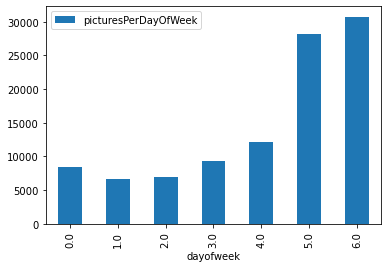

In [45]:
combine_all_data['dayofweek']=combine_all_data['Date'].dt.dayofweek
combine_all_data.groupby(['dayofweek']).agg(picturesPerDayOfWeek=('SourceFile','count')).plot(kind="bar")

In [46]:
df_no_home=combine_all_data[(combine_all_data['Place']!='Genf')& (combine_all_data['Place']!='Meyrin')
                            & (combine_all_data['Place']!='Lauchringen')
                            ].groupby(['year']).agg(DaysPerYear=('Day','nunique'),DaysInYear=('leapyear','median'))
df_no_home['DaysPerYearRatio']=df_no_home['DaysPerYear']/df_no_home['DaysInYear']
df_no_home.drop(columns=['DaysInYear'])

,DaysPerYear,DaysPerYearRatio
year,,
2006,13,0.035616
2007,15,0.041096
2008,35,0.095628
2009,46,0.126027
2010,43,0.117808
2011,33,0.090411
2012,47,0.128415
2013,55,0.150685
2014,56,0.153425


In [47]:
combine_all_data[combine_all_data['Date'].isna()][['SourceFile','Date','CreateDate']]

,SourceFile,Date,CreateDate
5530,/2009/090623 USA CTEQ09/090703 New York City/P...,NaT,NaN
18475,/2011/Lauchringen/P4240022-P420024 - Lauchring...,NaT,NaN
18514,"/2011/Private/PC310001 - Rust, Matthias im Eur...",NaT,NaN
53786,/2016/160910 Verbier & Hermence/P9110084 - Her...,NaT,NaN
53787,/2016/160910 Verbier & Hermence/P9110085 - Her...,NaT,NaN
53788,/2016/160910 Verbier & Hermence/P9110086 - Her...,NaT,NaN
53789,/2016/160910 Verbier & Hermence/P9110087 - Her...,NaT,NaN
53790,/2016/160910 Verbier & Hermence/P9110088 - Her...,NaT,NaN
53791,/2016/160910 Verbier & Hermence/P9110089 - Her...,NaT,NaN
53792,/2016/160910 Verbier & Hermence/P9110090 - Her...,NaT,NaN


<AxesSubplot:title={'center':'monthly count of  pictures'}, xlabel='Date', ylabel='picture count'>

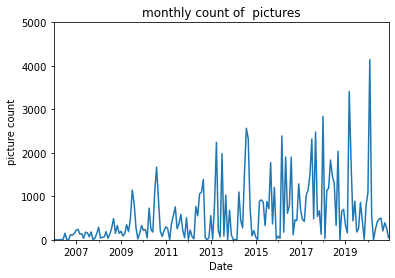

In [48]:
combine_all_data['Date']=pd.to_datetime(combine_all_data['Date'], utc=True)
#combine_all_data['Date'] = combine_all_data['Date'].dt.tz_localize(timezone.utc)
combine_all_data.groupby(pd.Grouper(key="Date", freq="M")).count()["SourceFile"].plot(title="monthly count of  pictures",ylabel="picture count",ylim=(0,5000))

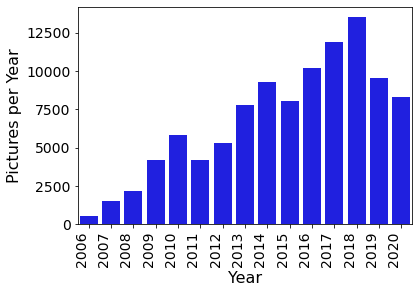

In [49]:
df_group=combine_all_data.groupby(pd.Grouper(key="Date", freq="Y")).count()["SourceFile"].reset_index()

ax = sns.barplot(x="Date", y="SourceFile", data=df_group,color = 'blue') 
x_dates = df_group['Date'].dt.strftime('%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right')
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('Pictures per Year',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

In [50]:
combine_all_data.groupby([combine_all_data["Date"].dt.hour]).count()

,SourceFile,Aperture,BitsPerSample,ColorSpace,Contrast,Date,ExposureTime,FileName,Flash,FocalLength in mm,...,WhiteBalance,Place,year,dayperiod,CompositePhoto,Movie,Country,Day,leapyear,dayofweek
Date,,,,,,,,,,,,,,,,,,,,,
0.0,351,343,351,351,337,351,343,351,343,343,...,343,351,351,351,351,351,351,343,351,351
1.0,509,500,509,509,480,509,500,509,500,500,...,500,509,509,509,509,509,509,509,509,509
2.0,595,588,595,595,580,595,588,595,588,588,...,588,595,595,595,595,595,595,595,595,595
3.0,598,589,598,598,587,598,589,598,589,589,...,589,598,598,598,598,598,598,597,598,598
4.0,430,425,430,430,425,430,425,430,425,425,...,425,430,430,430,430,430,430,427,430,430
5.0,458,452,458,458,449,458,452,458,452,452,...,452,458,458,458,458,458,458,458,458,458
6.0,998,985,998,998,933,998,985,998,985,985,...,985,998,998,998,998,998,998,980,998,998
7.0,2030,1981,2030,2030,1701,2030,1981,2030,1981,1981,...,1981,2030,2030,2030,2030,2030,2030,2012,2030,2030
8.0,4632,4552,4632,4632,3900,4632,4552,4632,4552,4552,...,4552,4632,4632,4632,4632,4632,4632,4610,4632,4632


In [51]:
test_sth=combine_all_data.groupby(combine_all_data["Date"].dt.dayofyear)[['SourceFile','Aperture']].count().sort_values(by=['SourceFile'], ascending=False)
test_sth

,SourceFile,Aperture
Date,,
250.0,1437,1415
249.0,1396,1380
251.0,1390,1374
252.0,1070,1059
207.0,948,914
...,...,...
67.0,1,1
102.0,1,0
303.0,1,0


In [52]:
index_in=test_sth.index.values
range_in=list(range(1,367))

In [53]:
days_no_photos = set(index_in).symmetric_difference(set(range_in))
days_no_photos

{22, 30, 38, 268, 270, 287, 328}

In [54]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains("Dom|Duomo|Cathedral|Kathedrale|cathedral")])

10604

In [55]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(r'(?=.*Koeln)(?=.*Dom)',regex=True)])

187

In [56]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Versailles)(?=.*Schloss)',regex=True)])

990

In [57]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Potsdam)(?=.*Sanssouci)',regex=True)])

711

In [58]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Kathedrale)(?=.*Genf)',regex=True)])

398

In [59]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Chapelle)(?=.*Paris)',regex=True)])

205

In [60]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Notre)(?=.*Paris)',regex=True)])

184

In [61]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Borghese)(?=.*Rom)',regex=True)])

187

In [62]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Maria Maggiore)(?=.*Rom)',regex=True)])

181

In [63]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Peter)(?=.*Rom)',regex=True)])

435

In [64]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Sagrada)(?=.*Barcelona)',regex=True)])

224

In [65]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Paris)(?=.*Saint)',regex=True)])

333

In [66]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*om)(?=.*Mailand)',regex=True)])

435

In [67]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Siena)(?=(.*Duomo|.*Dom))',regex=True)])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


321

In [68]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Palast|Chateau|Castle|Palace|Schloss|Residenz|Palazzo|Palais|palast|Reggia|Castelo|Burg|burg|Villa|Eremitage|Belvedere")])

28324

In [69]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rathaus|Hotel de Ville")])

1239

In [70]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Oper|Opera|Theatre|Teatro|heater|Staatsoper")])

1290

In [71]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Grotta|Grottes|Cave|Grotte|hoehle|Hoehle")])

1596

In [72]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Unter&Grindelwald&gletscher")])

0

In [73]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Mer de Glace")])

291

In [74]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "See|Lac|Lake|Lago")])

2475

In [75]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Grenzgletscher|Gornergletscher")])

209

In [76]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Mont Blanc")])

296

In [77]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Matterhorn")])

288

In [78]:
len(combine_all_data["SourceFile"][(combine_all_data["SourceFile"].str.contains(
    "Lateran")) & (~combine_all_data["SourceFile"].str.contains(
    "palast"))& (~combine_all_data["SourceFile"].str.contains(
    "Schatzkammer"))])

203

In [79]:
len(combine_all_data["SourceFile"][(combine_all_data["SourceFile"].str.contains(
    r'(?=.*Rom)(?=.*Palazzo Quirinale)',regex=True)) | (combine_all_data["SourceFile"].str.contains("Quirinals"))])

207

In [80]:
len(combine_all_data["SourceFile"][(combine_all_data["SourceFile"].str.contains(
    r"(?=.*)(?=.*Jungfraufirn)",regex=True))]) 

223

In [81]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r"(?=.*)(?=.*Aareschlucht)",regex=True)])

189

In [82]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    r'(?=.*Berlin)(?=.*Reichstag)',regex=True)])

47

In [83]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Gorge|Gorges|chlucht|Canyon|klamm")])

2052

In [84]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Neuschwanstein")])

101

In [85]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "fall|Falls|Cascade|foss|Ringquelle")])

1027

In [86]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "gletscher|Gletscher|Glacier|hiacciaio|Eismeer|firn|Plateau Rosa")])

5973

In [87]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Museo|Museum|museum|Uffizien|Museen|Eremitage|Louvre")])

4522

In [88]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    ", Aareschlucht")])

76

In [89]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Monet")])

70

In [90]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Goya")])

7

In [91]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Picasso")])

63

In [92]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rodin")])

32

In [93]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Dali")])

196

In [94]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Miro")])

32

In [95]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Gogh")])

22

In [96]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Chagall")])

29

In [97]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Kandinsky")])

22

In [98]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Max Ernst")])

12

In [99]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Brueghel")])

27

In [100]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Canova")])

33

In [101]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Michelangelo")])

60

In [102]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Raffael")])

111

In [103]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "da Vinci")])

42

In [104]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rembrandt")])

32

In [105]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Giotto")])

11

In [106]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rubens")])

82

In [107]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Botticelli")])

14

In [108]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Lippi")])

7

In [109]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Gauguin")])

10

In [110]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Rothko")])

8

In [111]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Cezanne")])

17

In [112]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Giacometti")])

5

In [113]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Hodler")])

10

In [114]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Franz Marc")])

2

In [115]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "Moschee|moschee/Cami")])

137

In [116]:
len(combine_all_data["SourceFile"][combine_all_data["SourceFile"].str.contains(
    "St Denis")])

115

In [117]:
#baroque
#Santa Maria Maggiore, Il Gesu, Sant'Ignazio, Theatinerkirche, Karlskirche, St Peter inside
#Santi Luca e Marina, Carlo alle Quattro Fontane, Andrea alla Quirinale, Louvre (Colonnade)
#Santa Maria della Salute, Sorbonne, Chateau de Maisons, Vaux-le-Vicomte, Palazzo Barberini, Versailles
#Louvre (part), Wuerzburg, Residenz Muenchen, Nymphenburg, Charlottenburg, Quirinale, Palazzo Pitti, 
#Passau, Salzburg, Caserta, Versailles, Naples, Schoenbrunn, Ludwigsburg, Mannheim, Rastatt
#Peter & Paul Krakow, Superga, Carignano, Madama, St Pauls, Greenwich Hospital, Blenheim Palace, Belvedere Vienna, 
#Clementinum Prague, Amalia Library, Santa Maria della Pace, Sapienza, Spanish Steps,Radcliffe Camera,
#Royal Palace Amsterdam, Palais Rohan, Poppelsdorf, Bonn, Benrath, Dresden (Innen)
#Hampton Court, Windsor Castle, Castle Howard, Chatsworth House, Castello del Valentino
#Lecce, Noto, Waldstein Palace, San Lorenzo Torino, Mafra Palace, Palazzo Reale Genua
#Aranjuez, Royal Palace Madrid, Schloss Eggenberg, Alte Residenz Salzburg, Het Loo Palace, Ksiaz Castle
#Torino, Venaria, Vaux-le-Vicomte, Winter Palace, Marinsky, Andre Kiev
#Puschkin, Peterhof, Peter & Paul Fortress, La Granja, Trevi Fountain, Cave Monastery Kiev
#Wilanow Palace, Zwinger, Frauenkirche, Pommersfelden, Goedoello, Fertoed
#Dome Invalides, Val de Grace, Drottningholm, Stockholm Palace, Fredensborg Palace, Amalienborg
#Tallin Catherinethal, Champs-sur-Marne

In [118]:
#gothic
#Westminster Abbey, "Westminster Hall","Old Hampton Court","old Eltham","old Hatfield","Stirling Castle","Conciergerie"
#Cathedral: Reims, Amiens, Orleans, Chartres, St Denis, Paris, Bourges, Strasbourg, Lyon
#Cathedral Canterbury, Chester, Glasgow, Edinburgh, Lincoln
#Duomo Milan, Siena, Hohensalzburg
#Dom Koeln, Frauenkirche, Regensburg, Stephansdom
#St Chapelle Paris, Vincennes, Christ Church College, King's College
#Scrovegni Chapel, Matthiaskirche, Kensington Palace
#Windsor Castle Church, Windsor Castle Church, Bath Abbey
#Prager Burg alt, Conciergerie, Vincennes
#Toledo, Segovia,Sevilla cathedrals, new cathedral Salamanca
#Maulbronn, Burgos Cathedral, Orvieto, St Maria sopra minerva
#Brussels Town Hall, La Llotja Valencia, Belfry Bruges
#Palais Papale, St Martin Landshut, Rouen, York Minster, Freiburg Minster, Ulm, Lorenz Nuernberg
#Brussels Cathedral, Antwerp Cathedral, Leuxen Town Hall, Mechelen Cathedral, Belfry Ghent, Albi Cathedral
#Palazzo Publico, Nieuwe Kerk Amsterdam, Wroclaw Town Hall, Mary Church, Krakow , Krakow Cathedral
#Faountains Abbey, Oranienbaum, Strelna, Palace of the Marquis of Dos Aguas, Skokloster, Dolmabahce
#Jeronimos Monastery, Leon, Avila, Valencia Cathedral, Bern Minster, Bodleian Library, St Mary Luebeck, Dom Schwerin, Luebeck

In [119]:
#classicism
#Wiesbaden, Chiswick House, Buckingham Palace, Capitol
#Petit Trianon, Chateau Bagatelle, Hotel de Salm, Compiegne, Academy Athens, Parliament Vienna, 
#Malmaison, Royal Palace Wroclaw, Menshikov, Stroganov
#Schloss Bellevue
#Isaac Cathedral, Pawlovsk, Gatchina, Somerset House, Budapest St Stephan, St Anna Warsaw, Prado,
#British Museum, Marmorpalais, Palaces on the Isle, Warsaw Royal Palace, Pantheon, Arc-et-Senans
#Palais Bourbon, Madelaine, Arc de Triomphe, 
#Galleria Borghese, Favorite Ludwigsburg, Wilhelmshoehe, Caserta, Capodimonte, 
#Kathedrale, Schlosskirche Kopenhagen,St Blasien
#Woerlitz, St Martin in the Fields, British Museum, Museumsinsel, Charlottenhof, Glienicke
#Glyptothek, Propylaeen, Koenigsbau Innen
#Brussels Royal Palace, Eisenstadt, Assisi Basilica, Santa Croce Florence, Palazzo Pitti (old quarters)

In [120]:
#romanesque
#Cathedral Rochester, Ely, Peterborough, Durham, Pisa, Worms, Mainz, Bamberg, Speyer, Limburg
#old Salamanca
#Hildesheim Michael, Cluny, Cloister Laterano, Cefalu, Palermo, Monreale
#Fontenay, St Savin
#Santa Maria in Cosmedin, Bitonton, Tower of London, Santiago de Compostela, Mt St Michel, Battistero Firenze, Cremona, Laterano
#Mt Saint-Michel, Vezelay, La Seu Lisbon, old Cathedral Coimbra, St Sernin, San Isidro Leon, Reichenau
#Arles, Trogir, Basel, Anagni crypt, Aquileia crypt, Bitonto, Molfetta, Trani, Bari Dom & Cathedral
#Castel del Monte, Wartburg, Rochester Castle, Canterbury Castle, Palazzo della Ragione Padua, Mantua, Genua
#Bayeux

In [121]:
#renaissance
#Hatfield House, Michaelskirche, Hofkirche Innsbruck, Palazzo Farnese, Sistine Chapel
#Blois, Chambord, Chenonceau, Fontainebleau, Louvre (Hof), Place des Voges, Amboise
#Palazzo Vecchio, Palazzo Ducale, Palazzo Te (Mantua), Palazzo Ducale (Venice), Laurentian Library Florence
#Hotel d'Assezat, St Eustache, St-Etienne-du-Mont, Certosa di Pavia, Scuola Grande di San Rocco
#Landshut Residenz, City Hall Bremen, Heidelberg, Rathaus Augsburg, Johannisburg Aschaffenburg
#Residenz Hof, City Hall Antwerp, Palazzo Schifanoia, Scuola Grande di San Marco
#University Salamanca, San Marco Leon, Charles V Alhambra, El Escorial, Granada Cathedral
#Villa Farnesina, Stanze Raffaele, Tempietto, Teatro Olympico, Villa Rotonda, Queen's House
#San Spirito, San Lorenzo, Palazzo Strozzi, Palazzo Medici Riccardi, Santa Maira Novella, Palazzo Rucellai
#Palazzo Ducale Urbino, Palazzo dei Diamanti, Santa Maria della Grazie, Prague Belvedere
#Banqueting Hall, Wawel Castle, Tomar Cloister, Belem Tower, Sao Roque, Frederiskborg, Pienza, Santa Maria degli Angeli Rome
#Kronborg, Rosenborg, Colleoni Chapel, Pazzi Chapel, Santa Maria della Pace, Ca d'Oro
#Biblioteca Marciana Venice, Basilica Palladiana (Vicenza), Cloth Hall Krakow, Concento San Esteban
#Gripsholm

In [122]:
#neobaroque

In [123]:
#neogothic
#"Votivkirche","Washington, National Cathedral", "NYC, St Patrick's Cathedral", "NYC, St John's Divine","Liverpool, Cathdral"
#Parlament London, Budapest, Strawberry Hill, Guildhall London

In [124]:
#rokoko
#Amalienburg, Sanssouci
#Wieskirche, Vierzehnheiligen
#Hotel Soubise, Hotel de Lassay, Hotel Matignon, Hotel de la Marine
#Ca Rezzonico, Wuerzburg Residenz, Solitude, Cuvilies, Augustusburg, Schaezlerpalais
#Queluz, Neues Schloss & eremitage Bayreuth, Bayreuth Theater
#Melk, Stupigini, Doria-Pamphilj, Katharinenschloss
#Bruchsal,Asamkirche, Seehof

In [125]:
#neoromanesque

In [126]:
#neorenaissance

In [127]:
#neobyzantine
#"Westminster Cathedral"